Sampled dataset shape: (947, 20)
Epoch 01 — Loss: 0.7639 — Acc: 0.3752 — LR: 0.01000
Epoch 02 — Loss: 0.7508 — Acc: 0.3791 — LR: 0.01000
Epoch 03 — Loss: 0.7373 — Acc: 0.3844 — LR: 0.01000
Epoch 04 — Loss: 0.7234 — Acc: 0.3989 — LR: 0.01000
Epoch 05 — Loss: 0.7094 — Acc: 0.4267 — LR: 0.01000
Epoch 06 — Loss: 0.6953 — Acc: 0.4597 — LR: 0.01000
Epoch 07 — Loss: 0.6814 — Acc: 0.5152 — LR: 0.01000
Epoch 08 — Loss: 0.6678 — Acc: 0.5733 — LR: 0.01000
Epoch 09 — Loss: 0.6546 — Acc: 0.6222 — LR: 0.01000
Epoch 10 — Loss: 0.6417 — Acc: 0.6579 — LR: 0.01000
Epoch 11 — Loss: 0.6293 — Acc: 0.7107 — LR: 0.01000
Epoch 12 — Loss: 0.6174 — Acc: 0.7517 — LR: 0.01000
Epoch 13 — Loss: 0.6060 — Acc: 0.7834 — LR: 0.01000
Epoch 14 — Loss: 0.5952 — Acc: 0.8203 — LR: 0.01000
Epoch 15 — Loss: 0.5849 — Acc: 0.8349 — LR: 0.01000
Epoch 16 — Loss: 0.5750 — Acc: 0.8494 — LR: 0.01000
Epoch 17 — Loss: 0.5655 — Acc: 0.8692 — LR: 0.01000
Epoch 18 — Loss: 0.5561 — Acc: 0.8811 — LR: 0.01000
Epoch 19 — Loss: 0.5469 — Acc: 

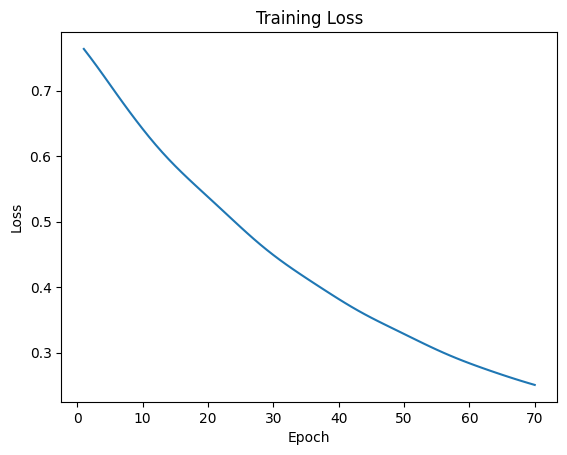

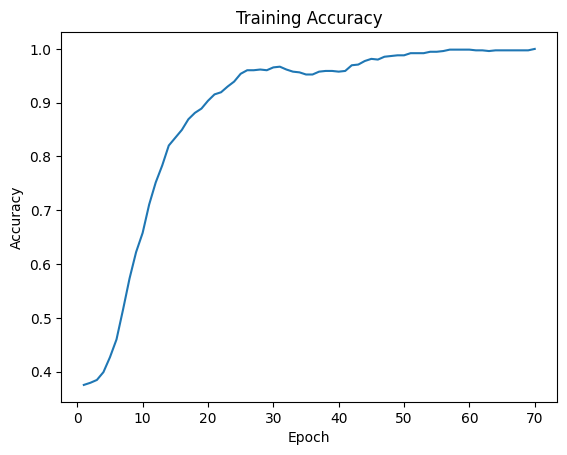

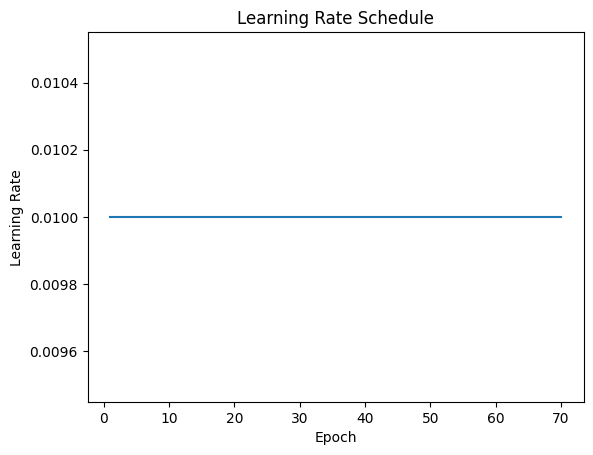


--- Test Metrics ---
Accuracy       : 1.0000
Precision      : 1.0000
Recall         : 1.0000
F1 Score       : 1.0000
ROC-AUC Score  : 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       110
           1       1.00      1.00      1.00        80

    accuracy                           1.00       190
   macro avg       1.00      1.00      1.00       190
weighted avg       1.00      1.00      1.00       190



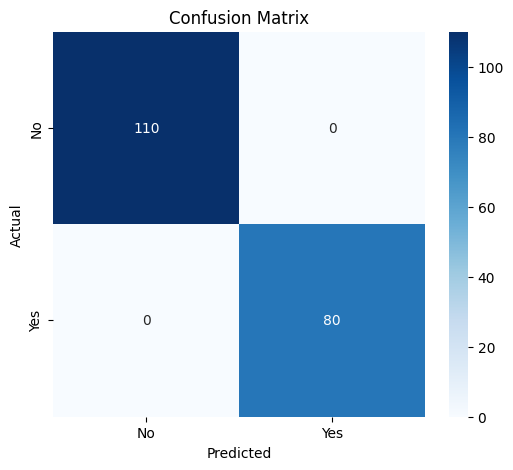

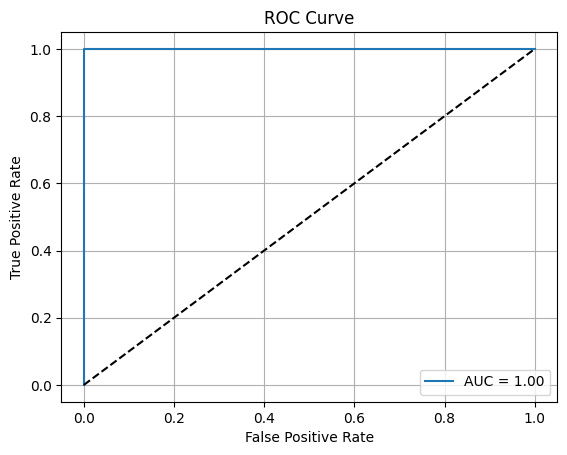


Test Accuracy (VQC): 1.0000

Saved updated metrics to outputs/model_results.csv


In [ ]:
#  Working with the full dataset combined

import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

# ------------------------
# 📊 DATA LOADING 
# ------------------------

# G-COLAB paths
# files = [
#     "/content/Autism-Child-Data.csv",
#     "/content/Autism-Adolescent-Data.csv",
#     "/content/Autism-Adult-Data.csv"
#     # "/content/Autism-Toddler-Data.csv"
# ]

# VS_Code
files = [
    "processed/Autism-Child-Data.csv",
    "processed/Autism-Adolescent-Data.csv",
    "processed/Autism-Adult-Data.csv"
]

# ------------------------
# 📊 PREPROCESSING
# ------------------------

df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
df = df.dropna().drop_duplicates()

target_col = 'Class/ASD'
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
if target_col in cat_cols:
    cat_cols.remove(target_col)
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

df[target_col] = df[target_col].map({'NO': 0, 'YES': 1})
df = shuffle(df, random_state=42).reset_index(drop=True)
# df_small = df.iloc[:200]
df_small=df

y = df_small[target_col].values
X = df_small.drop(target_col, axis=1).values
print(f"Sampled dataset shape: {X.shape}")

scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

torch.manual_seed(42)
X_train_t = torch.from_numpy(X_train).float()
y_train_t = torch.from_numpy(y_train).float()
X_test_t  = torch.from_numpy(X_test).float()
y_test_t  = torch.from_numpy(y_test).float()

# ------------------------
# ⚛️ QUANTUM CIRCUIT SETUP
# ------------------------
n_qubits = 2
n_layers = 3
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch", diff_method="backprop")
def circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs[:n_qubits], wires=list(range(n_qubits)))
    qml.templates.StronglyEntanglingLayers(weights, wires=list(range(n_qubits)))
    return [qml.expval(qml.PauliZ(w)) for w in range(n_qubits)]

weight_shapes = {"weights": (n_layers, n_qubits, 3)}
qlayer = qml.qnn.TorchLayer(circuit, weight_shapes)

class VQCModel(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.pre_net  = nn.Linear(in_features, n_qubits)
        self.q_net    = qlayer
        self.post_net = nn.Sequential(nn.Linear(n_qubits, 1), nn.Sigmoid())

    def forward(self, x):
        x = self.pre_net(x)
        q_outs = torch.stack([self.q_net(x[i]) for i in range(x.shape[0])], dim=0)
        out = self.post_net(q_outs)
        return out.view(-1)

# Instantiate model, optimizer, loss
dim_in = X_train.shape[1]
model     = VQCModel(dim_in)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn   = nn.BCELoss()

# ------------------------
# 🚀 TRAINING
# ------------------------
epochs = 70
loss_history = []
acc_history = []
lr_history = []

for epoch in range(1, epochs+1):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_t)
    loss    = loss_fn(outputs, y_train_t)
    loss.backward()
    optimizer.step()

    preds = (outputs.detach().cpu().numpy() > 0.5).astype(int)
    acc   = accuracy_score(y_train, preds)

    # record metrics
    loss_history.append(loss.item())
    acc_history.append(acc)
    lr_history.append(optimizer.param_groups[0]['lr'])

    print(f"Epoch {epoch:02d} — Loss: {loss.item():.4f} — Acc: {acc:.4f} — LR: {lr_history[-1]:.5f}")

# ------------------------
# 📈 PLOTTING METRICS
# ------------------------
# Loss
plt.figure()
plt.plot(range(1, epochs+1), loss_history)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Accuracy
plt.figure()
plt.plot(range(1, epochs+1), acc_history)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Learning Rate
plt.figure()
plt.plot(range(1, epochs+1), lr_history)
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.show()

# ------------------------
# 🧪 EVALUATION
# ------------------------
model.eval()
with torch.no_grad():
    test_out   = model(X_test_t)
    test_preds = (test_out.cpu().numpy() > 0.5).astype(int)
    test_acc   = accuracy_score(y_test, test_preds)

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve
)
import seaborn as sns

# Ensure model is in eval mode
model.eval()
with torch.no_grad():
    test_out   = model(X_test_t)
    test_preds = (test_out.cpu().numpy() > 0.5).astype(int)
    test_probs = test_out.cpu().numpy()

# 📊 METRICS
acc     = accuracy_score(y_test, test_preds)
prec    = precision_score(y_test, test_preds)
recall  = recall_score(y_test, test_preds)
f1      = f1_score(y_test, test_preds)
auc     = roc_auc_score(y_test, test_probs)
report  = classification_report(y_test, test_preds)

print("\n--- Test Metrics ---")
print(f"Accuracy       : {acc:.4f}")
print(f"Precision      : {prec:.4f}")
print(f"Recall         : {recall:.4f}")
print(f"F1 Score       : {f1:.4f}")
print(f"ROC-AUC Score  : {auc:.4f}")
print("\nClassification Report:")
print(report)

# 🔷 Confusion Matrix
cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 🔷 ROC Curve
fpr, tpr, _ = roc_curve(y_test, test_probs)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

print(f"\nTest Accuracy (VQC): {test_acc:.4f}")

# ------------------------------------------------
# 📦 SAVE THIS MODEL'S METRICS
# ------------------------------------------------
import os

# Load previous results if they exist
results_path = "outputs/model_results.csv"
if os.path.exists(results_path):
    all_results_df = pd.read_csv(results_path, index_col=0)
else:
    all_results_df = pd.DataFrame()

# Add this model's results (VQC)
vqc_results = {
    "accuracy": acc,
    "precision": prec,
    "recall": recall,
    "f1_score": f1,
    "roc_auc": auc
}
all_results_df.loc["VQC_Model"] = vqc_results

# Save updated results
os.makedirs("outputs", exist_ok=True)
all_results_df.to_csv(results_path)
print(f"\nSaved updated metrics to {results_path}")



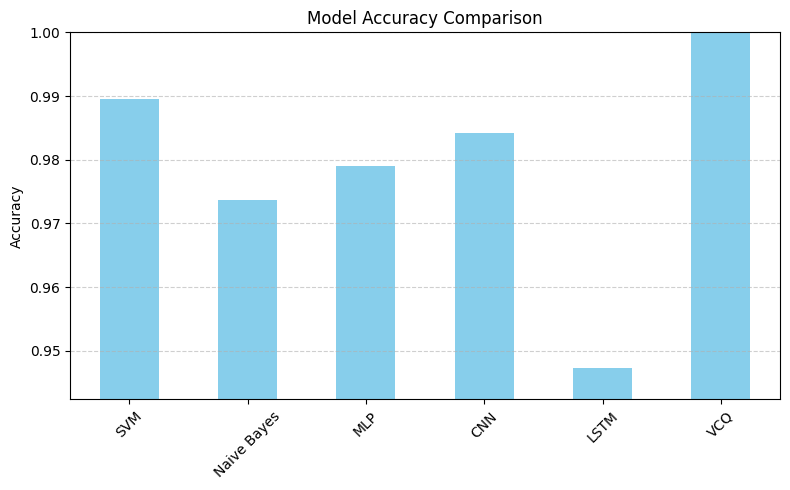

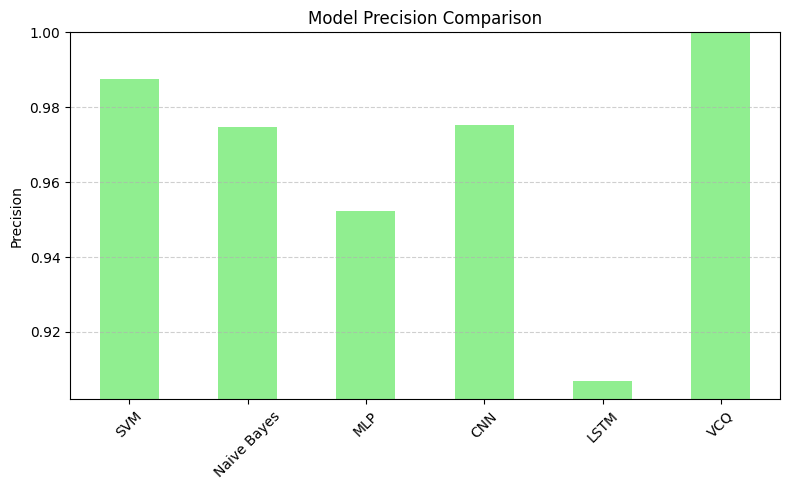

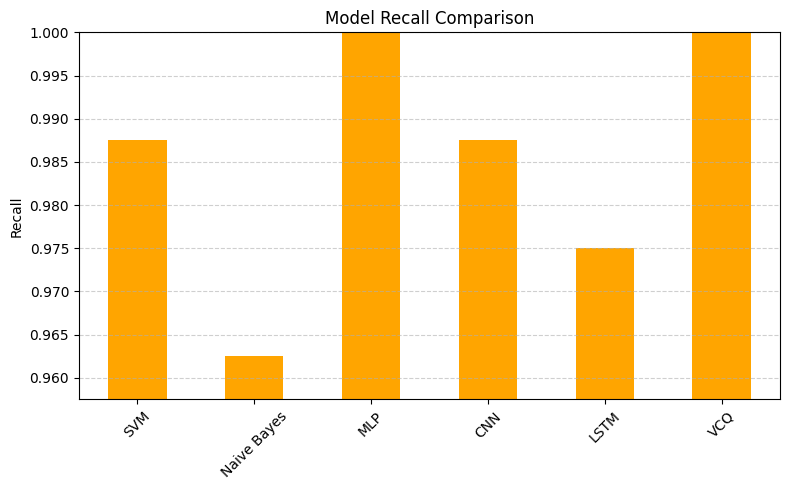

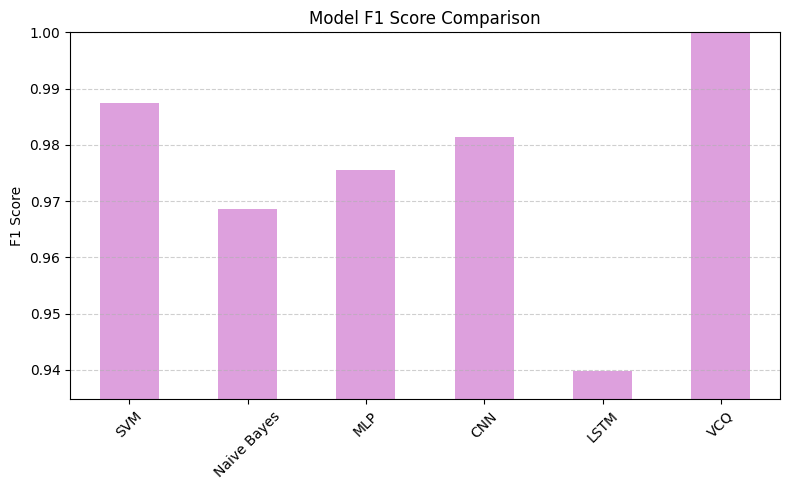

In [9]:
# ------------------------------------------------
# 📊 COMPARISON GRAPHS ACROSS ALL MODELS (ZOOMED)
# ------------------------------------------------

import numpy as np

results_df = pd.read_csv(results_path, index_col=0)

def plot_metric(metric, color):
    plt.figure(figsize=(8,5))
    results_df[metric].plot(kind='bar', color=color)

    # dynamic zoomed y-limit
    col = results_df[metric].dropna()
    ymin = max(0, col.min() - 0.005)
    ymax = min(1.0, col.max() + 0.005)
    if ymax - ymin < 0.02:   # if still very close, enforce small range
        center = (ymax+ymin)/2
        ymin = max(0, center - 0.02)
        ymax = min(1, center + 0.02)

    plt.ylim(ymin, ymax)
    plt.title(f"Model {metric} Comparison")
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

plot_metric('Accuracy', 'skyblue')
plot_metric('Precision', 'lightgreen')
plot_metric('Recall', 'orange')
plot_metric('F1 Score', 'plum')
